In [1]:
#codes/segmentation_setup.py

import os
import numpy as np
from pathlib import Path
from collections import Counter

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# SAM-2
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator


#Custom
# from config import *


/home/ascott10/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    print(f"using device: {device}")

    return device

In [3]:
device = set_device()

CLASS_VALUES = {
        "background": 0,    # black
        "artifact":   0,    # black
        "spike":      128,  # gray
        "body":       255,  # white
    }


using device: cuda


In [4]:
def show_anns(
    anns,
    image_shape,
    edge_margin=2,
    large_frac=0.1,
    small_frac=0.005,
    center_frac=0.25,
):
    if len(anns) == 0:
        return None

    H, W = image_shape[:2]
    IMG_AREA = H * W

    # class → pixel value
    CLASS_VALUES = {
        "background": 0,    # black
        "artifact":   0,    # black
        "spike":      128,  # gray
        "body":       255,  # white
    }

    # Sorts all masks by pixel area, from largest to smallest. If two masks overlap, the one later overwrites earlier pixels so if spike overlays body, the spike mask will supercede body mask. Also, body will not overwrite background
    sorted_anns = sorted(anns, key=lambda x: x["area"], reverse=True)

    # find body bbox first (required for spikes)

    #Initialize - if no body, then no body
    body_bbox = None

    #Iterate over masks, largest to smallest
    for ann in sorted_anns:
        x, y, w, h = ann["bbox"]

        #Normalize mask's area to a fraction of the image
        area_frac = ann["area"] / IMG_AREA

        #Compute center of the bounding box
        cx, cy = x + w / 2, y + h / 2

        #Test whether the object is centered
        centered = (
            abs(cx - W / 2) < center_frac * W and
            abs(cy - H / 2) < center_frac * H
        )

        #If it is large and centered, it is probably the body
        if area_frac >= large_frac and centered:
            body_bbox = ann["bbox"]

            #Stop this loop after finding the body
            #The first match is probably the best match
            break

    # Expand body bbox by 100 px if it exists
    if body_bbox is not None:
        bx, by, bw, bh = body_bbox
        body_cx = bx + bw / 2
        body_cy = by + bh / 2

    # single-channel semantic mask of uint8
    semantic_mask = np.zeros((H, W), dtype=np.uint8)

    # iterate through each mask in larger to small area order
    for ann in sorted_anns:

        # Extract the binary mask, where m is a 2D boolean area(HxW)
        m = ann["segmentation"]

        #Unpack the bounding box where x,y is top-left corner and w,h is size of the box
        x, y, w, h = ann["bbox"]

        #Normalize obect size
        area_frac = ann["area"] / IMG_AREA

        #Find the bottom right corner of the bbox
        x1, y1 = x + w, y + h

        #classification rules

        touches_edge = (
            #Left side of box is within edge-margin(i.e. 2 pixels) of left image border
            x <= edge_margin or

            #Top of box is within edge-margin(i.e. 2 pixels) of top image border
            y <= edge_margin or

            #Right side of box is within edge-margin(i.e. 2 pixels) of right image border
            x1 >= W - edge_margin or

            #Bottom of box is within edge-margin(i.e. 2 pixels) of bottom image border
            y1 >= H - edge_margin
        )

        #Define the background - if any of the pixels touches the edge (x = 0,1)
        if touches_edge:
            label = "background"
        else:

            #compute the bounding box center
            cx, cy = x + w / 2, y + h / 2

            #if center_frace = 0.25, the object must be within the central 50% of the image
            centered = (

                #Horizontal/Vertical distance from center < allowed distance threshold
                abs(cx - W / 2) < center_frac * W and
                abs(cy - H / 2) < center_frac * H
            )

            #Define the virus body
            #If the obect is large (>5% of the image (large_frac=0.05) and is centered)
            if area_frac >= large_frac and centered:
                label = "body"

            #Define a spike
            #Otherwise if the area is very small (<0.2%)
            elif area_frac <= small_frac:

                #If there is no body --> there are no spikes
                
                if body_bbox is not None:
                    dist = np.sqrt((cx - body_cx)**2 + (cy - body_cy)**2)
                    if dist <=0.5 * max(bw,bh): 

                        label = "spike"
                    else:
                        label = "artifact"
                else:
                    label = "artifact"

            #Otherwise it is medium-sized, noise, fragment, etc
            else:
                label = "artifact"

        ann["predicted_class"] = label

        # write semantic value 
        semantic_mask[m] = CLASS_VALUES[label]

    return semantic_mask


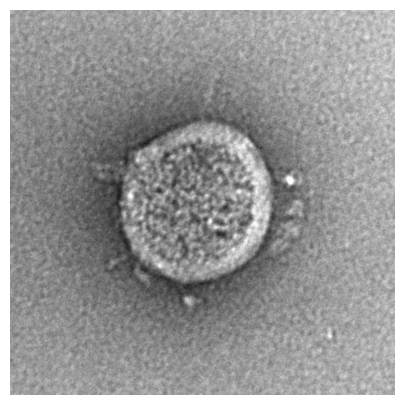

In [5]:
image = Image.open('/home/ascott10/documents/projects/pub_viruses/renamed_images/102.png')
image = np.array(image.convert("RGB"))

plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
import random
CLASS_VALUES = {
        "background": 0,    # black
        "artifact":   0,    # black
        "spike":      128,  # gray
        "body":       255,  # white
    }

sam2_checkpoint = "/home/ascott10/documents/projects/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(
    model_cfg,
    sam2_checkpoint,
    device=device,
    apply_postprocessing=False,
)

mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=48,
    points_per_batch=64,
    pred_iou_thresh=0.65,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    box_nms_thresh=0.7,
    min_mask_region_area=15.0,
    use_m2m=False,
)


def run_sam(image, show=True):
    masks2 = mask_generator_2.generate(image)

    # semantic mask: 0 / 128 / 255
    img_mask = show_anns(masks2, image.shape)

    if show:
        BOX_COLORS = {
        "background": "black",
        "artifact":   "black",
        "spike":      "gray",
        "body":       "white",
    }


        fig, ax = plt.subplots(1, 3, figsize=(10, 30))

        ax[0].imshow(image)
        ax[0].set_axis_off()

        ax[1].imshow(image)
        for m in masks2:
            x, y, w, h = m["bbox"]
            label = m["predicted_class"]
            ax[1].add_patch(
                plt.Rectangle(
                    (x, y),
                    w,
                    h,
                    fill=False,
                    edgecolor=BOX_COLORS[label],
                    linewidth=2,
                )
            )
        ax[1].set_axis_off()

        ax[2].imshow(image)
        ax[2].imshow(img_mask, cmap="gray", vmin=0, vmax=255)
        ax[2].set_axis_off()

        plt.show()

    return img_mask


In [7]:
print(next(sam2.parameters()).device)


cuda:0


In [ ]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

ids = random.sample(range(1, 930), 929)

for i in ids:
    image_id = f"{i:03d}"
    save_path = os.path.join("sam_masks", f"mask_{image_id}.png")

    # skip if already processed
    if os.path.exists(save_path):
        continue

    image = Image.open(
        f"/home/ascott10/documents/projects/pub_viruses/renamed_images/{image_id}.png"
    )
    image = np.array(image.convert("RGB"))

    img_mask = run_sam(image, show=False)
    print("finished image", image_id)

    plt.imsave(
        save_path,
        img_mask,
        cmap="gray",
        vmin=0,
        vmax=255,
    )


/home/ascott10/documents/projects/sam2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/home/ascott10/documents/projects/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


finished image 151
finished image 347
finished image 270
finished image 372
finished image 356
finished image 546
finished image 316


In [ ]:



ids = range(1,130)

for i in ids:
    image_id = f"{i:03d}"

    image = Image.open(
        f"/home/ascott10/documents/projects/pub_viruses/renamed_images/{image_id}.png"
    )
    image = np.array(image.convert("RGB"))

    img_mask = run_sam(image, show=False)
    print("finished image ", image_id)

    plt.imsave(
        os.path.join("sam_masks", f"mask_{image_id}.png"),
        img_mask,
        cmap="gray",
        vmin=0,
        vmax=255,
    )

/home/ascott10/documents/projects/sam2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/home/ascott10/documents/projects/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


finished image  001
finished image  002
finished image  003
finished image  004
finished image  005
finished image  006
finished image  007
finished image  008
finished image  009
finished image  010
finished image  011
finished image  012
finished image  013
finished image  014
finished image  015
finished image  016
finished image  017
finished image  018
finished image  019
finished image  020
finished image  021
finished image  022
finished image  023
finished image  024
finished image  025
finished image  026
finished image  027
finished image  028
finished image  029
finished image  030
finished image  031
finished image  032
finished image  033
finished image  034
finished image  035
finished image  036
finished image  037
finished image  038
finished image  039
finished image  040
finished image  041
finished image  042
finished image  043
finished image  044
finished image  045
finished image  046
finished image  047
finished image  048
finished image  049
finished image  050


In [ ]:
ids = range(131,929)

for i in ids:
    image_id = f"{i:03d}"

    image = Image.open(
        f"/home/ascott10/documents/projects/pub_viruses/renamed_images/{image_id}.png"
    )
    image = np.array(image.convert("RGB"))

    img_mask = run_sam(image, show=False)
    print("finished image ", image_id)

    plt.imsave(
        os.path.join("sam_masks", f"mask_{image_id}.png"),
        img_mask,
        cmap="gray",
        vmin=0,
        vmax=255,
    )